In [1]:
import os
import torch
from torchvision import datasets, transforms

from torchvision.io import read_image

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, img_dir: str):
        self.img_dir = img_dir
        
        self.images = []
        for file in os.listdir(self.img_dir):
            if file.endswith(".jpg"):
                full_path = os.path.join(self.img_dir, file)
                self.images.append(full_path)
        
        self.num_imgs = len(self.images)
        
    def __len__(self):
        return self.num_imgs
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = read_image(img_path) / 127.5 - 1
        return image
        

In [4]:
monet_ds = CustomImageDataset("./data/monet_jpg")
monet_data = torch.utils.data.DataLoader(monet_ds, shuffle=True)

photo_ds = CustomImageDataset("./data/photo_jpg")
photo_data = torch.utils.data.DataLoader(photo_ds, shuffle=True)

In [5]:
print("# of monet images: ", monet_ds.num_imgs)
print("# of photos: ", photo_ds.num_imgs)

# of monet images:  300
# of photos:  7038


In [6]:
example_monet = next(iter(monet_data))
example_photo = next(iter(photo_data))

In [7]:
example_monet.size()

torch.Size([1, 3, 256, 256])

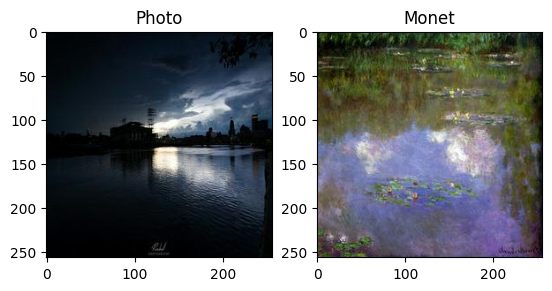

In [8]:
import matplotlib.pyplot as plt

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0].permute(1, 2, 0) * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0].permute(1, 2, 0) * 0.5 + 0.5)

## Build generator

In [9]:
import torch.nn as nn

In [10]:
INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 3

In [11]:
def downsample(in_channels, filters, size, apply_instancenorm=True):
    layers = []
    
    conv2d = nn.Conv2d(in_channels=in_channels, out_channels=filters, kernel_size=size, stride=2, padding=1, bias=False)
    nn.init.normal_(conv2d.weight, mean=0.0, std=0.02)
    layers.append(conv2d)
    
    if apply_instancenorm:
        instance_norm = nn.InstanceNorm2d(num_features=filters)
        layers.append(instance_norm)
        
    layers.append(nn.LeakyReLU())
    
    return nn.Sequential(*layers)

In [12]:
def upsample(in_channels, filters, size, apply_dropout=False):
    layers = []
    
    conv2d = nn.ConvTranspose2d(in_channels=in_channels, out_channels=filters, kernel_size=size, stride=2, padding=1, bias=False)
    nn.init.normal_(conv2d.weight, mean=0.0, std=0.02)
    layers.append(conv2d)
    
    instance_norm = nn.InstanceNorm2d(num_features=filters)
    layers.append(instance_norm)
    
    if apply_dropout:
        layers.append(nn.Dropout(p=0.5))
        
    layers.append(nn.LeakyReLU())
    
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.down_stack = nn.ModuleList(
            [
                downsample(in_channels=3, filters=64, size=4, apply_instancenorm=False),
                downsample(in_channels=64, filters=128, size=4),
                downsample(in_channels=128, filters=256, size=4),
                downsample(in_channels=256, filters=512, size=4),
                downsample(in_channels=512, filters=512, size=4),
                downsample(in_channels=512, filters=512, size=4),
                downsample(in_channels=512, filters=512, size=4),
                downsample(
                    in_channels=512, filters=512, size=4, apply_instancenorm=False
                ),  # (bs, 1, 1, 512)
            ]
        )

        # adding dimensions to the input channels because of the skip connections
        self.up_stack = nn.ModuleList(
            [
                upsample(in_channels=512, filters=1024, size=4, apply_dropout=True),
                upsample(
                    in_channels=1024 + 512, filters=1024, size=4, apply_dropout=True
                ),
                upsample(
                    in_channels=1024 + 512, filters=1024, size=4, apply_dropout=True
                ),
                upsample(in_channels=1024 + 512, filters=1024, size=4),
                upsample(in_channels=1024 + 512, filters=512, size=4),
                upsample(in_channels=512 + 256, filters=256, size=4),
                upsample(
                    in_channels=256 + 128, filters=128, size=4
                ),  # (bs, 128, 128, 128)
            ]
        )

        conv2d = nn.ConvTranspose2d(
            in_channels=128 + 64,
            out_channels=OUTPUT_CHANNELS,
            kernel_size=4,
            stride=2,
            padding=1,
        )
        nn.init.normal_(conv2d.weight, mean=0.0, std=0.02)
        self.last = nn.Sequential(conv2d, nn.Tanh())

    def forward(self, x):
        # Downsampling the model
        skips = []
        for down in self.down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])

        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            #             x = torch.cat((x, skip), dim=1)
            x = torch.cat((x, skip))

        x = self.last(x)
        return x

## Build the Discriminator

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.down_stack = nn.ModuleList(
            [
                downsample(in_channels=3, filters=64, size=4, apply_instancenorm=False),
                downsample(in_channels=64, filters=128, size=4),
                downsample(in_channels=128, filters=256, size=4),
            ]
        )
        self.zeropad = nn.ZeroPad2d(padding=1)
        self.conv = nn.Conv2d(
            in_channels=256, out_channels=512, kernel_size=4, bias=False, stride=1
        )
        nn.init.normal_(self.conv.weight, mean=0.0, std=0.02)

        self.instance_norm = nn.InstanceNorm2d(num_features=512)
        self.leaky_relu = nn.LeakyReLU()
        self.last = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1)
        nn.init.normal_(self.last.weight, mean=0.0, std=0.02)

    def forward(self, x):
        for down in self.down_stack:
            x = down(x)

        x = self.zeropad(x)
        x = self.conv(x)
        x = self.instance_norm(x)
        x = self.leaky_relu(x)
        x = self.last(x)

        return x

In [15]:
monet_generator = Generator().to(device)
photo_generator = Generator().to(device)
monet_discriminator = Discriminator().to(device)
photo_discriminator = Discriminator().to(device)

In [16]:
# monet_generator = Generator()
# photo_generator = Generator()
# monet_discriminator = Discriminator()
# photo_discriminator = Discriminator()

In [17]:
example_photo_cuda = example_photo[0].to(device)
type(example_photo_cuda)

torch.Tensor

In [18]:
to_monet = monet_generator(example_photo_cuda).to("cpu")

In [19]:
to_monet.size()

torch.Size([3, 256, 256])

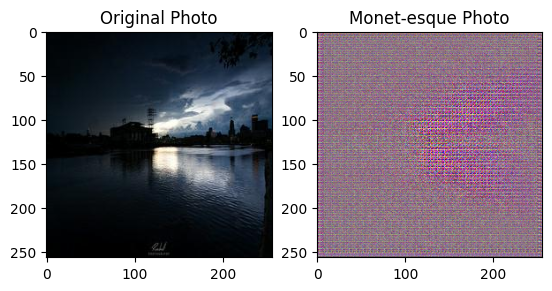

In [20]:
plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0].permute(1, 2, 0) * 0.5 + 0.5)

to_monet = to_monet.permute(1, 2, 0)
to_monet = to_monet.detach().numpy()
plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet * 0.5 + 0.5)
plt.show()

## Build the CycleGAN model

In [21]:
from itertools import cycle
from tqdm import tqdm 

In [22]:
class CycleGAN(nn.Module):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGAN, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
        # define optimizers
        self.m_gen_optimizer = torch.optim.Adam(self.m_gen.parameters(), 
                                                lr=2e-4, betas=(0.5, 0.999))
        self.p_gen_optimizer = torch.optim.Adam(self.p_gen.parameters(), 
                                                lr=2e-4, betas=(0.5, 0.999))
        self.m_disc_optimizer = torch.optim.Adam(self.m_disc.parameters(), 
                                                 lr=2e-4, betas=(0.5, 0.999))        
        self.p_disc_optimizer = torch.optim.Adam(self.p_disc.parameters(), 
                                                 lr=2e-4, betas=(0.5, 0.999))

    def discriminator_loss(self, real, generated):
#         real_loss = nn.BCEWithLogitsLoss(reduction='none')(torch.ones_like(real), real)
        real_loss = nn.BCEWithLogitsLoss()(torch.ones_like(real), real)
#         generated_loss = nn.BCEWithLogitsLoss(reduction='none')(torch.zeros_like(generated), generated)
        generated_loss = nn.BCEWithLogitsLoss()(torch.zeros_like(generated), generated)
        
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5 
    
    def generator_loss(self, generated):
#         return nn.BCEWithLogitsLoss(reduction='none')(torch.ones_like(generated), generated)
        return nn.BCEWithLogitsLoss()(torch.ones_like(generated), generated)
    
    def calc_cycle_loss(self, real_image, cycled_image, LAMBDA):
        loss = torch.mean(torch.abs(real_image - cycled_image))
        return LAMBDA * loss
    
    def identity_loss(self, real_image, same_image, LAMBDA):
        loss = torch.mean(torch.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss
    
    def train_step(self, monet_ds, photo_ds):
        running_monet_gen_loss = 0.0
        running_photo_gen_loss = 0.0
        running_monet_disc_loss = 0.0
        running_photo_disc_loss = 0.0
        # num_imgs = photo_ds.num_imgs
        
        for i, (real_monet, real_photo) in enumerate(zip(cycle(monet_ds), tqdm(photo_ds, ncols=100))):
            real_monet = real_monet.to(device)
            real_photo = real_photo.to(device)

            # zero the gradients for batch
            self.m_gen_optimizer.zero_grad()
            self.p_gen_optimizer.zero_grad()
            self.m_disc_optimizer.zero_grad()
            self.p_disc_optimizer.zero_grad()
        
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo)
            cycled_photo = self.p_gen(fake_monet)
            
            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet)
            cycled_monet = self.m_gen(fake_photo)
            
            # generating itself
            same_monet = self.m_gen(real_monet)
            same_photo = self.p_gen(real_photo)
            
            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet)
            disc_real_photo = self.p_disc(real_photo)
            
            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet)
            disc_fake_photo = self.p_disc(fake_photo)
            
            # evaluate generator loss
            monet_gen_loss = self.generator_loss(disc_fake_monet)
            # print("monet gen loss size: ", monet_gen_loss.size())
            photo_gen_loss = self.generator_loss(disc_fake_photo)
            
            # evaluate total cycle consistency loss
            monet_cycle_loss = self.calc_cycle_loss(real_monet, cycled_monet, self.lambda_cycle)
            # print("monet cycle loss: ", monet_cycle_loss)
            # print("monet cycle loss size: ", monet_cycle_loss.size())
            photo_cycle_loss = self.calc_cycle_loss(real_photo, cycled_photo, self.lambda_cycle)
            total_cycle_loss = monet_cycle_loss + photo_cycle_loss
            
            # evaluate total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss(real_monet, same_monet, self.lambda_cycle)
            running_monet_gen_loss += total_monet_gen_loss.item()
            # print("total monet gen loss size: ", total_monet_gen_loss.size())
            # print("total monet gen loss: ", total_monet_gen_loss.item())
            total_monet_gen_loss.backward(retain_graph=True)
            
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss(real_photo, same_photo, self.lambda_cycle)
            running_photo_gen_loss += total_photo_gen_loss.item()
            total_photo_gen_loss.backward(retain_graph=True)
            
            # evaluate total discriminator loss
            monet_disc_loss = self.discriminator_loss(disc_real_monet, disc_fake_monet)
            running_monet_disc_loss += monet_disc_loss.item()
            monet_disc_loss.backward(retain_graph=True)
            
            photo_disc_loss = self.discriminator_loss(disc_real_photo, disc_fake_photo)
            running_photo_disc_loss += photo_disc_loss.item()
            photo_disc_loss.backward()
            
            # Adjust the learning weights
            self.m_gen_optimizer.step()
            self.p_gen_optimizer.step()
            self.m_disc_optimizer.step()
            self.p_disc_optimizer.step()

        return {
            "monet_gen_loss": running_monet_gen_loss / i,
            "photo_gen_loss": running_photo_gen_loss / i,
            "monet_disc_loss": running_monet_disc_loss / i,
            "photo_disc_loss": running_photo_disc_loss / i
        }
            
    def train(self, epochs=25):
        for i in range(epochs):
            loss = self.train_step(monet_ds, photo_ds)
            print("Epoch {:d} | photo_gen_loss: {:.4f}; monet_gen_loss: {:.4f}; photo_disc_loss: {:.4f}; monet_disc_loss: {:.4f}".format(i+1, loss["photo_gen_loss"], loss["monet_gen_loss"], loss["photo_disc_loss"], loss["monet_disc_loss"]))

In [23]:
cycle_gan_model = CycleGAN(monet_generator=monet_generator,
                           monet_discriminator=monet_discriminator,
                           photo_generator=photo_generator,
                           photo_discriminator=photo_discriminator)

In [24]:
cycle_gan_model.train()

  9%|█████▏                                                    | 630/7038 [06:05<1:01:58,  1.72it/s]


KeyboardInterrupt: 